## Нюанс.
Данные имеют временные метки. 
Соответственно, split обязательно должен быть по времени.
- и при разделении на train - test
- и при кроссвалидации.
  
Так же и нормализовывать данные необходимо после разбиения.
- однако в этом случае качество моделей падает ниже плинтуса, то на эту утечку пока забью...)

## пробуем feature engineering
- поколышем amount
- докинем  rolling статистик (считаем только по данным из прошлого , потому применяю на всём датасете )
- ...

## 1. Импорты

In [ ]:
# Импорт библиотек
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (precision_score, recall_score, f1_score,
                            precision_recall_curve, auc, confusion_matrix)
import time
import warnings
warnings.filterwarnings('ignore')

# Конфигурация
RANDOM_STATE = 42
# Настройки отображения
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (8, 3)
plt.rcParams["figure.titlesize"] = 18
plt.rcParams['font.size'] = 12
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.linewidth"] = 3
# plt.rcdefaults()

## 2. Загрузка данных

In [ ]:
# поиск пути от текущего файла в папку
# anomaly_detection_project\data\raw где лежит датасет
def find_path_within_project(project_name, path_to_data):
    current_path = os.getcwd()   # путь к текущему файлу

    while True:
        # Проверяем, находится ли проект в текущем каталоге
        # если найден лепим и возвращаем нужный путь к данным
        if project_name in os.listdir(current_path):
            # Строим путь до нужной папки внутри проекта
            return os.path.join(current_path, project_name, path_to_data)

        parent_path = os.path.dirname(current_path)

        if parent_path == current_path:
            raise FileNotFoundError(f"Проект '{project_name}' не найден в родительских каталогах.")
        # если проекта нет поднимаемся выше
        current_path = parent_path

# Получаем путь
full_path_to_cc_1_02_00 = find_path_within_project(
    "anomaly_detection_project",
    os.path.join("data", "raw",'creditcard_1_02_00.csv' )
)

In [ ]:
# файл creditcard_1_02_00.csv лежит в папке data/raw/
# там добавлены новые колонки времени и суммы
# print(f"Загрузка данных из {full_path}")
df = pd.read_csv(full_path_to_cc_1_02_00)

# посмотрим ка
print("\n")
print(f"Размер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"Распределение классов:\n{df['Class'].value_counts(normalize=True)}")
print(f"\nДанные. Первые строки:")
display(df.head())
print("Список колонок без PCA: \n", *df.columns[~df.columns.str.startswith('V')])



Размер данных: 284807 строк, 35 столбцов
Распределение классов:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Данные. Первые строки:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,Time_hour,Time_day,Time_abs_hour,Amount_log
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,0.0,0.0,5.014760
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,0.0,0.0,1.305626
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0,0.0,0.0,5.939276
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0,0.0,0.0,4.824306
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0,0.0,0.0,4.262539


Список колонок без PCA: 
 Time Amount Class Time_hour Time_day Time_abs_hour Amount_log


## 3. Feature Engineering

### Amount

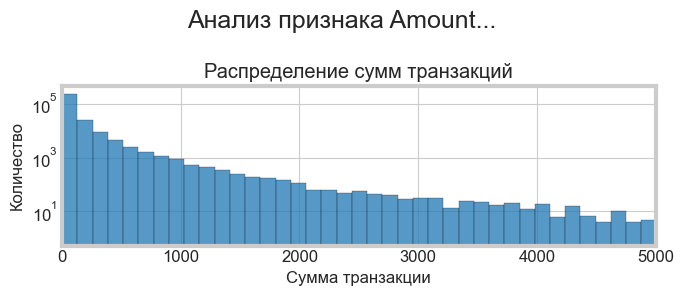

In [4]:
# Анализ суммы транзакций
plt.figure(figsize=(7, 3))
plt.suptitle("Анализ признака Amount...")
sns.histplot(df['Amount'], bins=200, kde=False)
plt.title('Распределение сумм транзакций')
plt.xlabel('Сумма транзакции')
plt.ylabel('Количество')
plt.yscale('log')
plt.xlim(0, 5000)  # Ограничиваем для лучшей визуализации
plt.show()

In [5]:
scaler = RobustScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount_log']])

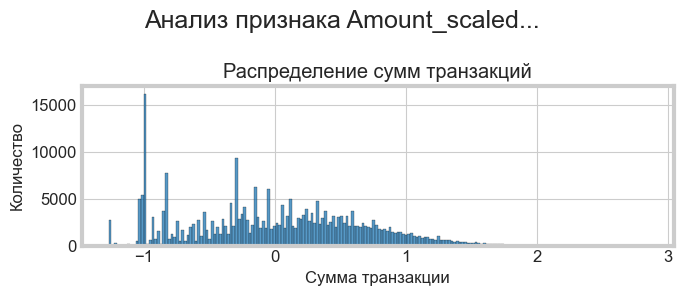

In [6]:
# Анализ суммы транзакций
plt.figure(figsize=(7, 3))
plt.suptitle("Анализ признака Amount_scaled...")
sns.histplot(df['Amount_scaled'], bins=200, kde=False)
plt.title('Распределение сумм транзакций')
plt.xlabel('Сумма транзакции')
plt.ylabel('Количество')
#plt.yscale('log')
#plt.xlim(0, 5000)  # Ограничиваем для лучшей визуализации
plt.show()

In [7]:
def rolling_by_time(
    df,
    cols,
    time_col='Time',
    window='10min',
    min_periods=1,
    stats=('mean', 'min', 'max', 'std'),
):
    """
    Возвращает DataFrame со скользящими статистиками по указанным колонкам
    за последние `window` минут.

    Параметры:
    - df: DataFrame с колонкой времени в секундах (time_col) и признаками
    - cols: список колонок для расчёта (или одна строка)
    - time_col: имя колонки времени (по умолчанию 'Time')
    - window: строка окна времени для pandas (по умолчанию '10min')
    - min_periods: минимальное число наблюдений в окне (по умолчанию 1)
    - stats: кортеж или список агрегаторов (по умолчанию ('mean', 'min', 'max', 'std'))

    Возвращает:
    - DataFrame с колонками вида <col>_roll_<window>_<stat> и индексом = значения time_col
    """
    import pandas as pd

    # Нормализуем список колонок
    if isinstance(cols, str):
        cols = [cols]

    needed = set(cols + [time_col])
    missing = needed.difference(df.columns)
    if missing:
        raise KeyError(f"В DataFrame отсутствуют колонки: {sorted(missing)}")

    # Сортируем по времени
    df_sorted = df.sort_values(time_col).copy()

    # Индекс-таймдельта из секунд
    df_sorted['__td__'] = pd.to_timedelta(df_sorted[time_col], unit='s')
    df_sorted = df_sorted.set_index('__td__')

    # Роллинг по прошлому окну
    roll = (
        df_sorted[cols]
        .rolling(window=window, min_periods=min_periods, closed='both')
        .agg(stats)
    )

    # Переименовываем колонки: <col>_roll_<window>_<stat>
    roll.columns = ['_'.join(col) + f'_roll_{window}' for col in roll.columns]

    # Собираем результат
    result = pd.concat([df_sorted[[time_col]], roll], axis=1)

    # Для одинаковых time_col оставить только последнюю строку
    result = result.groupby(time_col, as_index=False).tail(1)

    # Делаем time_col индексом
    result = result.set_index(time_col)
    return result

In [8]:
v_cols = [c for c in df.columns if c.startswith('V')]
cols = v_cols + ['Amount_scaled']  # при необходимости

rolling_func = rolling_by_time(df, cols=cols, time_col='Time', window='240 min',
                               stats=['std', 'median' ])

# слияем с исходным df по Time
df_with_roll = df.merge(rolling_func, left_on='Time', right_index=True, how='left')
print(f"размер новых данных {df_with_roll.shape }")

размер новых данных (284807, 94)


## 4. Уменьшение кол-ва признаков
Для классических алгоритмов поиска аномалий имеем явный перебор признаков , сократим
- PCA   
(понимаю, что в по честному нужно делать после разбиения на обучающую и тестовую выборку но и так не сладко будет...) 

In [ ]:
# для предсказания ни временные колонки ни величина транзакций нам не нужны
#  оставляем только  'Time_abs_hour' по ней будем бить на фолды
unnecessary_cols = ['Time', 'Amount', 'Time_hour', 'Time_day', 'Amount_log']

In [ ]:
from sklearn.decomposition import PCA, KernelPCA

# Сокращение
unchangeable_columns = ['Time_abs_hour', 'Class']
unchangeable_df = df_with_roll[unchangeable_columns]
features = df_with_roll.drop(columns=unchangeable_columns + unnecessary_cols)

# масштабируем
scaled_features = StandardScaler().fit_transform(features)

# PCA ( сохраняем 95% дисперсии)
pca = PCA(n_components=0.98)
features_pca = pca.fit_transform(scaled_features)


df_pca = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(features_pca.shape[1])])
df_final = pd.concat([unchangeable_df.reset_index(drop=True), df_pca], axis=1)

df_final.head()


,Time_abs_hour,Class,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38
0,0.0,0,16.867038,-20.286216,-22.900784,-8.195068,-6.454546,-2.507806,-9.808957,-12.172445,...,0.224727,-1.488502,-1.220640,-1.637121,1.751289,-2.218806,3.750042,4.965648,-1.805415,-4.021035
1,0.0,0,16.785660,-20.269536,-23.080571,-8.063818,-6.765057,-4.540363,-8.974322,-11.804093,...,0.088921,0.203397,-1.138693,-2.302072,1.126661,-2.558712,3.966819,4.329275,-2.627933,-3.734060
2,0.0,0,9.273977,-5.868007,-1.169685,-17.797694,21.966728,-1.662415,-3.499434,7.973287,...,-1.241261,0.606766,1.468031,0.370082,-3.333321,-17.477630,1.304132,-3.252706,-4.329255,-20.854488
3,0.0,0,9.115895,-5.844194,-1.290500,-17.734424,21.769514,-2.696494,-3.003050,8.233948,...,0.079290,0.345928,1.233024,-0.227761,-3.534627,-17.532398,1.784652,-4.162524,-3.988271,-20.627133
4,0.0,0,9.470067,-9.449658,-6.051790,-13.069359,13.505278,-2.164860,-2.982384,8.018953,...,-0.095876,0.917636,2.944353,0.445518,-1.338263,-11.393256,2.040279,-3.034809,-2.235999,-14.426417


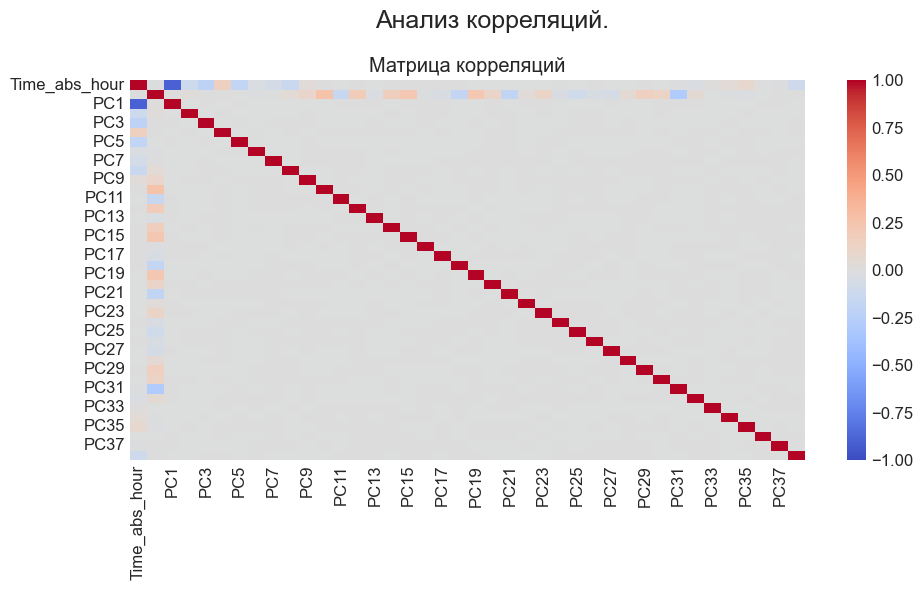


Корреляция признаков с целевой переменной:
Class            1.000000
PC10             0.261292
PC19             0.231419
PC15             0.230142
PC12             0.190904
PC14             0.167795
PC29             0.156579
PC30             0.121449
PC23             0.115909
PC20             0.115883
PC9              0.097669
PC28             0.056050
PC32             0.049699
PC8              0.046781
PC22             0.026573
PC2              0.018206
PC1              0.011731
PC37             0.007276
PC4              0.005976
PC3              0.002840
PC38             0.002798
PC7              0.000549
PC5             -0.003723
PC33            -0.007191
PC36            -0.007457
PC6             -0.010512
Time_abs_hour   -0.012326
PC16            -0.014622
PC34            -0.015487
PC35            -0.016379
PC13            -0.023825
PC24            -0.037493
PC26            -0.040877
PC17            -0.043155
PC27            -0.061814
PC25            -0.098375
PC11            -0.1

In [11]:
# Корреляционный анализ

corr_matrix = df_final.corr()

plt.figure(figsize=(10, 6))
plt.suptitle("Анализ корреляций.")
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляций')
plt.show()

# Корреляция с целевой переменной
class_corr = corr_matrix['Class'].sort_values(ascending=False)
print("\nКорреляция признаков с целевой переменной:")
print(class_corr)

## 5. Выделение test

In [ ]:
# Выделим для теста последние 8 часов
def get_train_test(df, col, train_finish,
                   train_start = 0, test_finish = 0, gap = 0,
                   easy_check =True):
    '''делим df на train и test
        - gap -зазор между train и test (возможно и не пригодиццо)
    '''
    # определяем test_start и test_finish
    if test_finish == 0:
        test_finish = df[col].max()
    test_start = train_finish + gap + 1
    df_train = df[(df[col] >= train_start) & (df[col] <= train_finish)]
    df_test =  df[(df[col] >= test_start) & (df[col] <= test_finish)]
    if  easy_check:
        print("easy checking: \n",
              f"train min {df_train[col].min()}, train max {df_train[col].max()}\n" ,
              f"test min {df_test[col].min()}, test max {df_test[col].max()}")
    return df_train, df_test


# колонка для сплита
time_column = 'Time_abs_hour'
# лимит трайна
train_finish = df_with_roll[time_column].max() - 8

df_train, df_test = get_train_test(df_final, time_column , train_finish)
print("\nОтрезали тестовую выборку.")
print(f"Размеры train:{df_train.shape} test: {df_test.shape} .")
print(f"Содержание пропусков в train {df_train.isna().sum().sum()}, в test {df_test.isna().sum().sum()} ")

easy checking: 
 train min 0.0, train max 39.0
 test min 40.0, test max 47.0

Отрезали тестовую выборку.
Размеры train:(224865, 40) test: (59942, 40) .
Содержание пропусков в train 0, в test 0 


## 6. Кросс валидация + обучение

In [ ]:
# домашняя кросс валидация с учётом временных меток
# возвращает позиционные индексы
class my_Time_Series_Fold_for_df:
    def __init__(self):
        self.folds = []


    def split(self, df, time_col, n_folds, rolling_window= True, talker = True):
        '''rolling_window - тактика формирования train'''

        self.talker = talker
        # Получаем временные метки
        time_values = df[time_col]
        min_time = time_values.min()
        max_time = time_values.max()
        ############
        print(min_time, max_time)

        # Общая продолжительность временного интервала
        total_time = max_time + 1 - min_time

        # Границы фолдов
        fold_time_limits = [total_time*i/(n_folds+1) + min_time for i in range(n_folds+2)]
        if self.talker:
            print("\n*** my_Time_Series_Fold_for_df ***\n")
            print(fold_time_limits)

        for i in range(n_folds):
            # Временные границы обучающей выборки
            # в зависимости от стратегии
            train_time_start = fold_time_limits[
                    i if rolling_window else 0
                ]
            train_time_end =  fold_time_limits[i+1]

            # Временные границы тестовой выборки
            # test_time_start = train_time_end
            test_time_end = fold_time_limits[i+2]

            # Формируем обучающую и тестовую выборки
            train_idx = df[(df[time_col] >= train_time_start) &
                            (df[time_col] < train_time_end)].index

            test_idx = df[(df[time_col] >= train_time_end) &
                            (df[time_col] < test_time_end)].index

            # Преобразуем метки в позиции
            train_pos = df.index.get_indexer(train_idx)
            test_pos = df.index.get_indexer(test_idx)
            if self.talker:
                print(f"Номер фолда {i+1}")
                print(f"Размер train: {len(train_pos)}, test: {len(test_pos)}")

            # Добавляем пары индексов в список фолдов
            self.folds.append((train_pos, test_pos))

        return self.folds

time_separator = my_Time_Series_Fold_for_df()

In [ ]:
# домашний unsupervised GridSearch для ocsvm, Isolation Forest, LOF
class my_GridSearchCV_for_df:
    '''
        Подбор гиперпараметров модели
        Разрешённые модели OCSVM, Isolation Forest, LOF(novelty = True)
        обучение возможно только на нормальных объектах или на всех
        cv - стратегия кросс валидации класс который формирует позиции
        X_train, y_train, X_test,  y_test по временной колонке
        n_samples - определяет сколько сэмплировать объектов для обучения,
        ибо для lof и для OCSVM размер выборки критичен
        drop_columns - колонки которые не учавствуют в обучении и предсказании

    '''
    def __init__(self, model, param_grid, cv = time_separator,  scoring = f1_score,
                 time_col = time_column, n_folds = 3, drop_columns = list(),
                 normalizer = None, n_samples = None, talker = True,
                 unsupervised = True, random_state=None):

        self.estimator = model
        self.drop_columns = drop_columns
        self.unsupervised = unsupervised
        self.param_grid = list(ParameterGrid(param_grid))   # dict словарь параметров
        self.cv = cv                                        # стратегия кроссвалидации
        self.scoring = scoring                              # ф-я оценки (y_true, y_pred) -> float, например f1_score
        self.time_col = time_col
        self.n_folds = n_folds
        self.normalizer = normalizer                         # LOF, OCSVM хотят нормализа
        self.n_samples = n_samples
        self.talker = talker
        self.random_state = random_state
                        # стратегия кросс валидации и обучения итоговой модели

    def fit(self, X, y, rolling_window = True):
        """ Перебирает все комбинации параметров и заполняет cv_results_.
            - X - df
            - y - Series
            - rolling_window - тактика формирования train и обучения
        """

        # структуры для хранения результатов
        all_params = []
        mean_test_scores = []
        std_test_scores = []

        # получаем разбиение по фолдам
        train_test_positions = self.cv.split(X, self.time_col,
                                             self.n_folds, rolling_window, self.talker)

        # добавляем в удаляемые колонку по которой делили
        self.drop_columns.append(self.time_col)

        # полный перебор
        for params in self.param_grid:
            test_scores = []

            # переделано под пандас получаем позици строк , не индексы!!!
            for train_pos, test_pos in train_test_positions:
                X_train, y_train = X.drop(self.drop_columns, axis=1).iloc[train_pos] , y.iloc[train_pos]
                X_test,  y_test  = X.drop(self.drop_columns, axis=1).iloc[test_pos] ,  y.iloc[test_pos]

                # если нужно стандартизировать выборку для обучения LOF, OCSVM
                # возможно это нужно делать после усечения train но пока так...
                if self.normalizer is not None:
                    # train
                    X_sc = self.normalizer.fit_transform(X_train)
                    # обратно в df
                    X_train = pd.DataFrame(X_sc, columns=X_train.columns, index=X_train.index)
                    # test
                    X_sc = self.normalizer.transform(X_test)
                    # обратно в df для тест наверное не нужно ...
                    X_test = pd.DataFrame(X_sc, columns=X_test.columns, index=X_test.index)

                # если нужно
                if self.unsupervised:
                    # в train только нормальные объекты
                    X_train = X_train[y_train == 0]

                # если нужно уменьшить выборку для обучения LOF, OCSVM
                if self.n_samples is not None:
                    np.random.seed(self.random_state)  # фиксируем генератор
                    indices = np.random.choice(len(X_train), size=self.n_samples, replace=False)
                    X_train = X_train.iloc[indices]

                # рожаем модель
                model = clone(self.estimator).set_params(**params)
                model.fit(X_train)

                # предсказания на test с инверсией
                y_pred = np.where(model.predict(X_test) == -1, 1, 0)
                test_scores.append(self.scoring(y_test, y_pred))

            all_params.append(params)
            mean_test_scores.append(np.mean(test_scores))
            std_test_scores.append(np.std(test_scores))
            if self.talker:
                print(f"\nПараметры {params}")
                print(f"mean_scores {mean_test_scores[-1]}")
                print(f"std {std_test_scores[-1]}")

        # собираем cv_results_
        # можно докинуть потом 'rank_test_score',
        #'split0_test_score', 'split1_test_score', ...: оценки на каждом фолде
        # 'mean_fit_time', 'mean_score_time': время обучения и оценки
        cv_results = {
            'params': all_params,
            'mean_test_score': np.array(mean_test_scores),
            'std_test_score':  np.array(std_test_scores),
        }

        # сохраняем результаты
        self.cv_results_  = cv_results

        # выбираем лучший индекс по mean_test_score
        best_idx = np.argmax(cv_results['mean_test_score'])
        self.best_params_  = all_params[best_idx]
        self.best_score_   = cv_results['mean_test_score'][best_idx]
        self.best_estimator_ = clone(self.estimator).set_params(**self.best_params_)

        # обучаем лучший на всей выборке кроме колонок которые нужно дропнуть
        X = X.drop(self.drop_columns, axis=1)

        # если тактика rolling_window обучаем только на данных последнего фолда
        if rolling_window:
            X, y  = X.iloc[test_pos] ,  y.iloc[test_pos]

        # если нужно стандартизировать выборку для обучения LOF, OCSVM
        # возможно это нужно делать после усечения train но пока так...
        if self.normalizer is not None:
            X_sc = self.normalizer.fit_transform(X)
            # обратно в df
            X = pd.DataFrame(X_sc, columns=X.columns, index=X.index)

        # только нормальные)
        if self.unsupervised:
            X = X[y==0]

        # если нужно уменьшить выборку для обучения LOF, OCSVM
        if self.n_samples is not None:
            indices = np.random.choice(len(X), size=self.n_samples*2, replace=False)
            X = X.iloc[indices]

        self.best_estimator_.fit(X)
        return

    def predict(self, X):
        """
        Предсказывает метки для X, используя best_estimator_.
        Возвращает 1 для нормальных и -1 для аномалий, как и ocsvm
        """
        self.check_best_estimator()
        X = X.drop(self.drop_columns, axis=1)

        # если нужно стандартизироввали выборку для обучения LOF, OCSVM то
        if self.normalizer is not None:
            X = self.normalizer.transform(X)

        return self.best_estimator_.predict(X)

    def decision_function(self, X):
        """
        Возвращает значение decision_function от best_estimator_.
        или
        """
        self.check_best_estimator()

        X = X.drop(self.drop_columns, axis=1)
        # если нужно стандартизировали выборку для обучения LOF, OCSVM
        if self.normalizer is not None:
            X = self.normalizer.transform(X)

        return self.best_estimator_.decision_function(X)

    def check_best_estimator(self):
        """
        проверка наличия обученого моделя
        """
        if not hasattr(self, 'best_estimator_'):
            raise AttributeError("Нужно сначала вызвать .fit()")

In [15]:
# для предсказания оставляем только колонки с PCA признаками и Amount_log ???
# Предобработка
drop_cols = ['Class']

X = df_train.drop(drop_cols, axis=1)
y = df_train['Class']

X_test = df_test.drop(drop_cols, axis=1)
y_test = df_test['Class']

In [16]:
print("Данные содержат колонки: ", X.columns)


Данные содержат колонки:  Index(['Time_abs_hour', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
       'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17',
       'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26',
       'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35',
       'PC36', 'PC37', 'PC38'],
      dtype='object')


## 7. Оценка

In [ ]:
###############################################################
# precision-recall кривая и confusion_matrix и метрики
# возвращаем предсказание аномалий 1, 0
def anomaly_predict(model, X):
    return np.where(model.predict(X) == -1, 1, 0)

# метрики печать и возвращаем f1, pr_auc
def print_metrics(y_true, y_pred,  pr_auc):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print('\n'+'='*60)
    print(f"Precision={precision:.2f},   Recall={recall:.2f},   F1={f1:.2f},   PR_AUC={pr_auc:.2f}")
    print('\n'+'='*60)
    # return f1, pr_auc

# precision-recall кривая и confusion_matrix
def plot_pr_curve_and_conf_matrix(model, X, y_true, main_label = ''):
    # 0) получаем предсказания и сырые и не очень)
    # получаем сырые оценки
    y_scores = - model.decision_function(X)

    # и предсказания
    y_pred = anomaly_predict(model, X)

    # 1) оценка pr_curve
    precisions, recalls, _ = precision_recall_curve(y_true, y_scores)
    # x  должен монотонно возрастать!!!!
    pr_auc = auc(x = recalls, y = precisions)

    # 2)отрисовка
    # # Создаём общую фигуру с 2 подграфиками (по горизонтали)
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    # pr curve
    fig.suptitle("Оценка модели " + main_label, fontsize=14, fontweight='bold')


    labels = ['Норм (0)', 'Аномалии (1)']

    axs[0].plot(recalls, precisions, marker='.', color='teal')
    axs[0].set_xlabel("Recall")
    axs[0].set_ylabel("Precision")
    axs[0].set_title(f"PR Curve (AUC={pr_auc:.2f})")

    # cm
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axs[1])
    axs[1].set_xlabel("Предсказаные метки")
    axs[1].set_ylabel("Истинные метки")
    axs[1].set_title("Confusion Matrix")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3) # раздвигаем картинки
    plt.show()

    # 3) печать метрик
    print_metrics(y_true, y_pred,  pr_auc)

    pass


################################################################

### LocalOutlierFactor(novelty=True)

In [ ]:
# Поиск гиперпараметров
lof = LocalOutlierFactor(novelty=True)

param_lof = {
    'n_neighbors': [ 15, 25, 35],
    'contamination': [ 0.001]
}


# лучшие показатели без нормализации
#normalizer = RobustScaler()

grid_lof =  my_GridSearchCV_for_df(
    model=lof,
    param_grid = param_lof,
    time_col = time_column,
    n_folds = 3,
    n_samples = 3000,
    # normalizer = normalizer,
    # drop_columns = unnecessary_cols,
    random_state = RANDOM_STATE
)
grid_lof.fit(X, y, rolling_window=False)

print( '\nЛучшие параметры модели: ', grid_lof.best_params_)

0.0 39.0

*** my_Time_Series_Fold_for_df ***

[0.0, 10.0, 20.0, 30.0, 40.0]
Номер фолда 1
Размер train: 30596, test: 80256
Номер фолда 2
Размер train: 110852, test: 45528
Номер фолда 3
Размер train: 156380, test: 68485

Параметры {'contamination': 0.001, 'n_neighbors': 15}
mean_scores 0.13941401433165676
std 0.14918352275443952

Параметры {'contamination': 0.001, 'n_neighbors': 25}
mean_scores 0.40774294272933737
std 0.16774104194422962

Параметры {'contamination': 0.001, 'n_neighbors': 35}
mean_scores 0.4113333577262545
std 0.20468892953182458

Лучшие параметры модели:  {'contamination': 0.001, 'n_neighbors': 35}


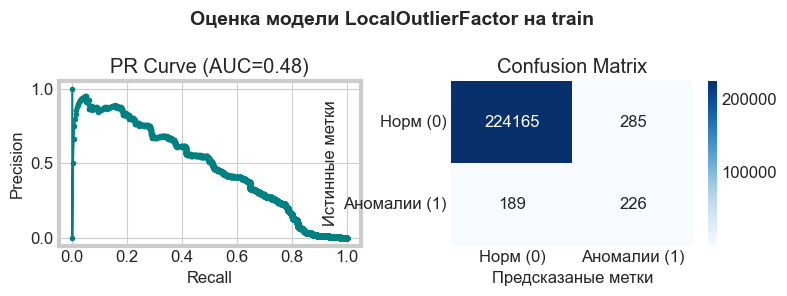


Precision=0.44,   Recall=0.54,   F1=0.49,   PR_AUC=0.48



In [ ]:
# Оценка на train
plot_pr_curve_and_conf_matrix(
    grid_lof,
    X,
    y,'LocalOutlierFactor на train'
)

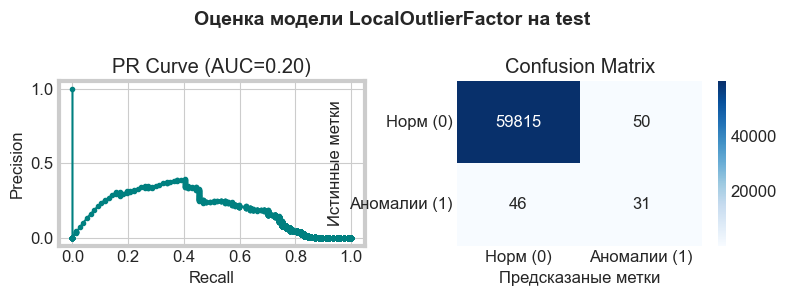


Precision=0.38,   Recall=0.40,   F1=0.39,   PR_AUC=0.20



In [ ]:
# Оценка на test
plot_pr_curve_and_conf_matrix(
    grid_lof, X_test,
    y_test,'LocalOutlierFactor на test'
)

### IsolationForest

In [ ]:
param_iso = {
    'n_estimators': [200, 300],
    'contamination': [ 0.001 ]
}
grid_iso =  my_GridSearchCV_for_df(
    model = IsolationForest(random_state=RANDOM_STATE),
    param_grid=param_iso,
    time_col = time_column,
    n_folds = 3,
    n_samples = 30000,
    # unsupervised = False,
    # drop_columns = unnecessary_cols,
    random_state=RANDOM_STATE
)
grid_iso.fit(X, y, rolling_window=False)

print( '\nЛучшие параметры модели: ', grid_iso.best_params_)

0.0 39.0

*** my_Time_Series_Fold_for_df ***

[0.0, 10.0, 20.0, 30.0, 40.0]
Номер фолда 1
Размер train: 30596, test: 80256
Номер фолда 2
Размер train: 110852, test: 45528
Номер фолда 3
Размер train: 156380, test: 68485

Параметры {'contamination': 0.001, 'n_estimators': 200}
mean_scores 0.14664817383263987
std 0.1442912781311427

Параметры {'contamination': 0.001, 'n_estimators': 300}
mean_scores 0.159457738830843
std 0.15649109240991876

Лучшие параметры модели:  {'contamination': 0.001, 'n_estimators': 300}


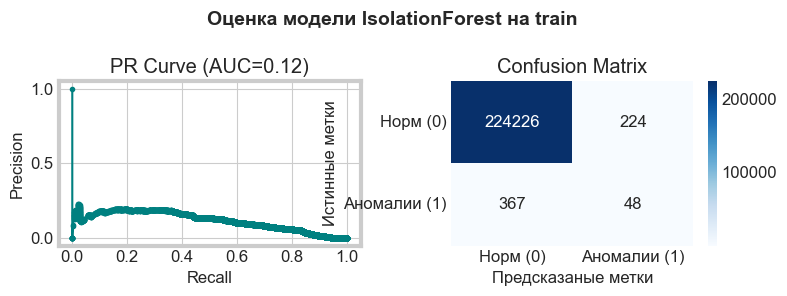


Precision=0.18,   Recall=0.12,   F1=0.14,   PR_AUC=0.12



In [ ]:
# Оценка на train
plot_pr_curve_and_conf_matrix(
    grid_iso,
    X,
    y,'IsolationForest на train'
)

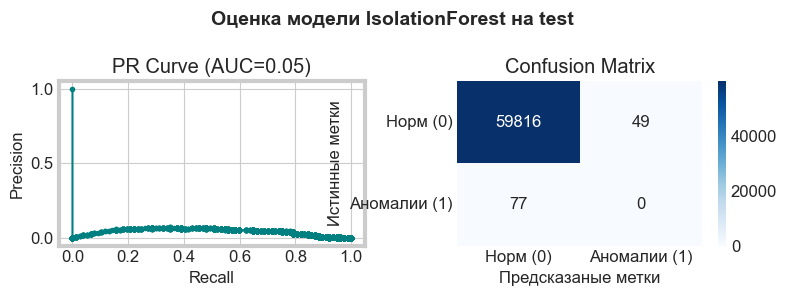


Precision=0.00,   Recall=0.00,   F1=0.00,   PR_AUC=0.05



In [ ]:
# Оценка на test
plot_pr_curve_and_conf_matrix(
    grid_iso, X_test,
    y_test,'IsolationForest на test'
)

### OneClassSVM

In [ ]:
from sklearn.svm import OneClassSVM
# Поиск гиперпараметров
ocsvm = OneClassSVM(kernel='rbf')

param_ocsvm = {
    'nu': [ 0.001, 0.0005],
    'gamma': ['scale',  0.005]
}

grid_ocsvm =  my_GridSearchCV_for_df(
    model=ocsvm,
    param_grid = param_ocsvm,
    time_col = time_column,
    n_folds = 3,
    n_samples = 3000,
    # drop_columns = unnecessary_cols,
    random_state = RANDOM_STATE
)
grid_ocsvm.fit(X, y, rolling_window=False)

print( '\nЛучшие параметры модели: ', grid_ocsvm.best_params_)

0.0 39.0

*** my_Time_Series_Fold_for_df ***

[0.0, 10.0, 20.0, 30.0, 40.0]
Номер фолда 1
Размер train: 30596, test: 80256
Номер фолда 2
Размер train: 110852, test: 45528
Номер фолда 3
Размер train: 156380, test: 68485

Параметры {'gamma': 'scale', 'nu': 0.001}
mean_scores 0.04223943197735062
std 0.037617074623848105

Параметры {'gamma': 'scale', 'nu': 0.0005}
mean_scores 0.042068712049021836
std 0.03738660841639192

Параметры {'gamma': 0.005, 'nu': 0.001}
mean_scores 0.056323669234976274
std 0.04731983182491898

Параметры {'gamma': 0.005, 'nu': 0.0005}
mean_scores 0.05601351353212006
std 0.046914593288702386

Лучшие параметры модели:  {'gamma': 0.005, 'nu': 0.001}


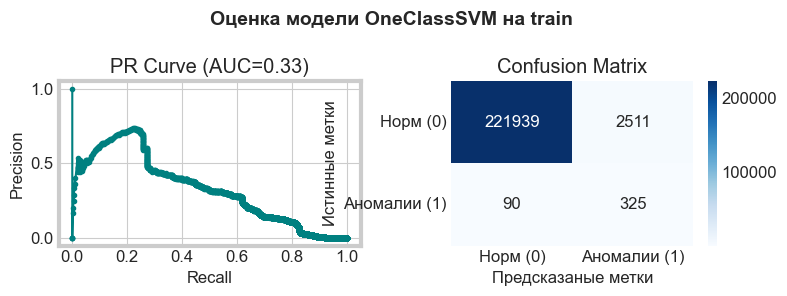


Precision=0.11,   Recall=0.78,   F1=0.20,   PR_AUC=0.33



In [ ]:
# Оценка на train

plot_pr_curve_and_conf_matrix(
    grid_ocsvm,
    X,
    y,'OneClassSVM на train'
)

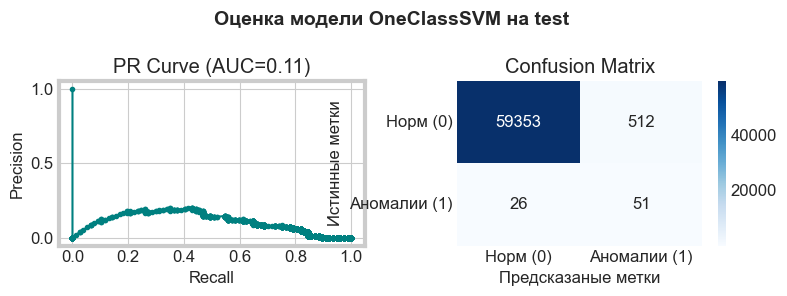


Precision=0.09,   Recall=0.66,   F1=0.16,   PR_AUC=0.11



In [ ]:
# Оценка на test
plot_pr_curve_and_conf_matrix(
    grid_ocsvm, X_test,
    y_test,'OneClassSVM на test'
)

## 6. Выводы

**Датасет**
- **Объём**: 284 807 транзакций, 35 признаков.
- **Ну очень сильный дисбаланс**: 0,17% транзакций — мошеннические (Class == 1).

**Временное разбиение**: данные разделены по `Time_abs_hour`:
  - **Train**: 0–39 часов (224 865 строк).  
  - **Test**: 40–47 часов (59 942 строк).
  
** Rolling статистики и Amount**  
- Принесли снижение качества.
  
**Вывод**
- Rolling статистики принесли ухудшение качества всех моделей , так как взяты по общему пулу всех пользователей и не помогают идентифицировать мошеннические транзакци.Мошенничество — это аномальная активность конкретного пользователя или карты, а не аномалия общего трафика